# Exercises 8: Mutual Information #

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as scist
from scipy import optimize

## 2. Density-Based Method ##

The file singleunit.py contains a function that simulates spike count output $\vec{k}$ of two neurons for a
stimulus with a single parameter $\theta_n=(n/12) \pi$, $n=0,...,11$.

In [2]:
import numpy as np
import scipy.stats as scist

def record(theta):

    mu1=10.*(np.cos(theta-np.pi/8)+1)/2
    
    mu2=2.*(np.cos(theta-5*np.pi/8)+1)/2

    k=np.zeros((2,len(theta)))
    noise=np.random.rand(2,len(theta))
    for n in range(len(theta)):
        th=theta[n]
        k[0,n]=scist.poisson.ppf(noise[0,n],mu1[n])
        k[1,n]=scist.poisson.ppf(noise[1,n],mu2[n])


    return k

(a) Sample $\vec{k}$ from 100 repetitions of each of the 12 stimuli (uniform distribution of $\theta$).

Thetas: [0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.57079633 1.83259571 2.0943951  2.35619449 2.61799388 2.87979327]


Text(0.5, 1.0, 'stimulus distribution')

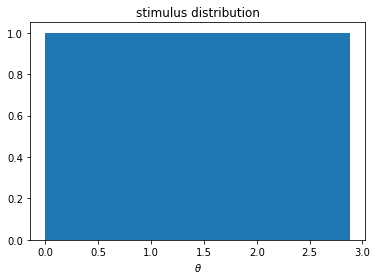

In [3]:
rep = 100
theta = np.pi * np.arange(0, 12, 1) / 12

print('Thetas:', theta)
plt.hist(theta, bins = 12)
plt.xlabel('$\\theta$')
plt.title('stimulus distribution')

In [4]:
k = np.zeros((2, len(theta), rep))

for i in range(rep):
    k[:, :, i] = record(theta)

(b) Find $\vec{\lambda}(\theta)$ using a maximum (log)likelihood approach for the model distribution

$$p(\vec{k}|\theta) = \frac{[\lambda_1(\theta)]^{k_1} [\lambda_2(\theta)]^{k_2}}{k_1! k_2!} exp[−\lambda_1(\theta) − \lambda_2(\theta)]$$

Use scipy.optimize.fmin to fit the parameters.

In [5]:
# functions for computing the negative log-likelihood and optimization
def negative_loglikelihood(guess_lambda, *args):
    # guess_lambda[0] = lambda_1, guess_lambda[0] = lambda_2
    log_lik = np.sum((k_1 * np.log(guess_lambda[0]) - guess_lambda[0])) + np.sum((k_2 * np.log(guess_lambda[1]) - guess_lambda[1])) # log-likelihood from product of two Poissons
    return -log_lik

def minimize_likelihood(guess_lambda, k_1, k_2):
    minimum = optimize.fmin(negative_loglikelihood, guess_lambda, args=(k_1,k_2))
    return minimum

In [6]:
lambdas = np.zeros((2, len(theta)))
guess_lambda = np.random.rand(2)

for i in range(len(theta)):
    k_1 = k[0, i, :]
    k_2 = k[1, i, :]
    lambdas[:, i] = minimize_likelihood(guess_lambda, k_1, k_2)

Optimization terminated successfully.
         Current function value: -1083.476602
         Iterations: 68
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: -1151.246503
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -1251.158352
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -1091.332845
         Iterations: 64
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: -792.087786
         Iterations: 63
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -756.566502
         Iterations: 61
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: -478.771917
         Iterations: 57
         Function evaluations: 112
Op

<ipython-input-5-07c847c79c2e>:4: RuntimeWarning: invalid value encountered in log
  log_lik = np.sum((k_1 * np.log(guess_lambda[0]) - guess_lambda[0])) + np.sum((k_2 * np.log(guess_lambda[1]) - guess_lambda[1])) # log-likelihood from product of two Poissons


In [7]:
print('lambda 1:\n', lambdas[0, :], '\nlambda 2:\n', lambdas[1, :])

lambda 1:
 [ 9.41998109  9.76998926 10.20997959  9.47996939  8.04002288  7.85000809
  6.38997829  5.32003821  4.11996519  3.1100099   1.92004293  0.95000351] 
lambda 2:
 [0.54000191 0.83998231 1.00001015 1.40000101 1.70000933 1.76998484
 1.91000133 2.11003145 1.84003114 2.01002296 1.51998532 1.61997884]


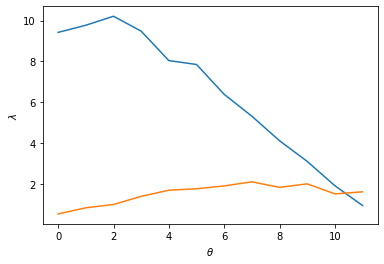

In [8]:
plt.plot(lambdas[0, :], )
plt.plot(lambdas[1, :])
plt.xlabel('$\\theta$')
_ = plt.ylabel('$\lambda$')

(c) Compute the entropy $H(K_i)$ of the marginal distribution of $p(k_i) = \sum_j p(k_i|\theta_j)p(\theta_j)$ by numerical summation over all $N$ samples $k^{(n)}_i$.


$$ H(K_i) = −N^{−1} \sum_{n=1}^{N} ln [\sum_j p(k_i^{(n)}|\theta_j)p(\theta_j)] $$

In [9]:
def entropy(k, rep, lambdas, p_theta):
    H = np.zeros(2)
    for i in range(k.shape[0]):
        curr_entropy = 0
        for j in range(rep):
            for l in range(len(p_theta)):
                curr_margin = 0
                for m in range(len(p_theta)):
                    curr_margin += marginal(k[i, l, j], lambdas[i, m], p_theta[m])
                curr_entropy += np.log(curr_margin)
        H[i] = -curr_entropy / (rep*len(p_theta))
    return H

def marginal(k, lam, p_theta):
    lik = (lam ** k) / (np.math.factorial(k)) * np.exp(-lam) * p_theta
    return lik

In [10]:
p_theta = np.full(len(theta), 1/12)

H = entropy(k, rep, lambdas, p_theta)

print('Entropy H(k1):', H[0])
print('Entropy H(k2):', H[1])

Entropy H(k1): 2.7512897604107653
Entropy H(k2): 1.5946193471370724


Neuron 1 has a larger variance (because it has a larger mean $\lambda$ which for a Poisson neuron then also determines the variance) and therefore higher entropy ("can produce richer code"). 

Analytically, we saw this also in 1.(c) where we derived that the entropy scales with the logarithm of $\sigma$.

(d) Compute the mutual information $I(\vec{K},\theta) = H(\vec{K}) − H(\vec{K}|\theta) = \sum_i [H(K_i) − H(K_i|\theta)]$ with the noise entropy 

$$H(K_i|\theta) = N^{−1} \sum_n [−k^{(n)}_i~ln(\lambda_i(\theta^{(n)})) + \lambda_i(\theta^{(n)}) + ln(k^{(n)}_i !)] $$

In [11]:
def mutual_information(H, H_noise, k, lambdas):
    mutual_information = np.sum(H - H_noise)
    return mutual_information

def noise_entropy(k, lambdas):
    H_noise = np.zeros((k.shape[0]))
    for i in range(k.shape[0]):
        curr_h = 0
        for j in range(k.shape[2]):
            for l in range(k.shape[1]):
                curr_h += -k[i, l, j] * np.log(lambdas[i, l]) + lambdas[i, l] + np.log(float(np.math.factorial(k[i, l, j])))
        H_noise[i] = curr_h / (rep*len(p_theta))
    return H_noise               

In [12]:
H_noise = noise_entropy(k, lambdas)
I = mutual_information(H, H_noise, k, lambdas)

print('Entropy H(k1):', H[0])
print('Noise entropy H(k1|theta):', H_noise[0])
print('Entropy H(k2):', H[1])
print('Noise entropy H(k2|theta):', H_noise[1])
print('Mutual information I:', I)

Entropy H(k1): 2.7512897604107653
Noise entropy H(k1|theta): 2.2674241497433067
Entropy H(k2): 1.5946193471370724
Noise entropy H(k2|theta): 1.5185907402889915
Mutual information I: 0.5598942175155395


For neuron 1, the difference between entropy and noise entropy is larger than for neuron 2. 

(e) Compute the upper bound

$$ I(\vec{K},\theta) = ln[1 + \frac{var(\theta)}{var(k_1)+var(k_2)}] / 2 $$

In [13]:
def upper_bound(theta, k):
    bound = np.log(1 + (np.var(theta) / (np.var(k[0, :, :]) + np.var(k[1, :, :]))) / 2)
    return bound

In [14]:
bound = upper_bound(theta, k)

print('Upper bound:', bound)

Upper bound: 0.02183763364130612


Note: there was a mistake in the upper bound formula.

(f) Repeat your computations for a prior distribution $p(\theta)$ in which $\theta_6$ occurs 10 times as often as all
the other $\theta$s.

Thetas: [0.         0.26179939 0.52359878 0.78539816 1.04719755 1.30899694
 1.30899694 1.30899694 1.30899694 1.30899694 1.30899694 1.30899694
 1.30899694 1.30899694 1.30899694 1.57079633 1.83259571 2.0943951
 2.35619449 2.61799388 2.87979327]


Text(0.5, 1.0, 'stimulus distribution')

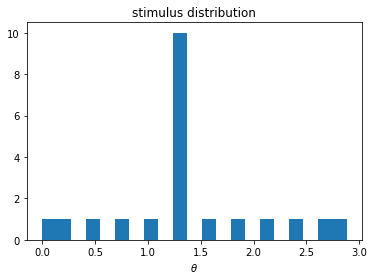

In [15]:
# (a)

rep = 100
theta_raw = np.pi * np.arange(0, 12, 1) / 12
theta = np.hstack((theta_raw[:5], np.full(10, theta_raw[5]), theta_raw[6:]))

print('Thetas:', theta)
plt.hist(theta, bins = 21)
plt.xlabel('$\\theta$')
plt.title('stimulus distribution')

In [16]:
k = np.zeros((2, len(theta), rep))

for i in range(rep):
    k[:, :, i] = record(theta)

In [17]:
# (b)

lambdas = np.zeros((2, len(theta)))
guess_lambda = np.random.rand(2)

for i in range(len(theta)):
    k_1 = k[0, i, :]
    k_2 = k[1, i, :]
    lambdas[:, i] = minimize_likelihood(guess_lambda, k_1, k_2)

Optimization terminated successfully.
         Current function value: -1196.481294
         Iterations: 53
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -1146.482693
         Iterations: 60
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: -1228.150313
         Iterations: 65
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -1211.335701
         Iterations: 61
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: -974.214804
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: -796.920013
         Iterations: 58
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -738.804575
         Iterations: 52
         Function evaluations: 99
Opt

<ipython-input-5-07c847c79c2e>:4: RuntimeWarning: invalid value encountered in log
  log_lik = np.sum((k_1 * np.log(guess_lambda[0]) - guess_lambda[0])) + np.sum((k_2 * np.log(guess_lambda[1]) - guess_lambda[1])) # log-likelihood from product of two Poissons


In [18]:
print('lambda 1:\n', lambdas[0, :], '\nlambda 2:\n', lambdas[1, :])

lambda 1:
 [ 9.95003767  9.73996175 10.11002297 10.00997681  8.93001847  8.11002926
  7.79000729  7.50006011  8.25999565  7.8099648   8.1400083   7.8399652
  7.87003255  7.54998539  8.09995719  6.2400675   5.26003048  4.35996927
  3.05004596  2.05996036  1.110018  ] 
lambda 2:
 [0.68998194 0.74999364 1.05999606 1.3800183  1.5300082  1.48999514
 1.66996976 1.82999703 1.90996683 1.80997602 1.89001604 1.99999359
 1.92999897 2.05002595 1.73999096 2.10001071 1.92999512 2.00996485
 2.06000125 1.76001294 1.42002266]


In [19]:
# (c)

p_theta = np.full(len(theta), 1/21)

H = entropy(k, rep, lambdas, p_theta)

print('Entropy H(k1):', H[0])
print('Entropy H(k2):', H[1])

Entropy H(k1): 2.693810124798059
Entropy H(k2): 1.6229517888915037


In [20]:
# (d)

H_noise = noise_entropy(k, lambdas)
I = mutual_information(H, H_noise, k, lambdas)

print('Entropy H(k1):', H[0])
print('Noise entropy H(k1|theta):', H_noise[0])
print('Entropy H(k2):', H[1])
print('Noise entropy H(k2|theta):', H_noise[1])
print('Mutual information I:', I)

Entropy H(k1): 2.693810124798059
Noise entropy H(k1|theta): 2.3238892274626264
Entropy H(k2): 1.6229517888915037
Noise entropy H(k2|theta): 1.5685764617767224
Mutual information I: 0.424296224450214


In [21]:
# (e)

bound = upper_bound(theta, k)

print('Upper bound:', bound)

Upper bound: 0.015299403236788025


Comment on 1.(f):

For both neurons, the difference between the entropy and noise entropy decreases (entropies decrease while noise entropies increase). Therefore, the mutual information becomes smaller because with the peaked stimulus distributions (distribution of thetas) because the output is more certain (less surprising / less variability), which leads to a smaller variability in the output and therefore variability that is still in the output is due to contribution of the noise.